In [1]:
train_image_folder = 'C:/Users/zecharpy/Desktop/Keras_bbox_regressor/tiny_train_img/'
train_annot_folder = 'C:/Users/zecharpy/Desktop/Keras_bbox_regressor/tiny_train_annot/'
valid_image_folder = 'C:/Users/zecharpy/Desktop/Keras_bbox_regressor/tiny_val_img/'
valid_annot_folder = 'C:/Users/zecharpy/Desktop/Keras_bbox_regressor/tiny_val_annot/'

In [18]:
from __future__ import absolute_import, division, print_function
import numpy as np
import argparse
import random
import os
from scipy import misc
from skimage import draw
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

def create_model(image_height=192, image_width=192, loss='mse', optimizer='adam'):
    """Creates the cat face locator model.
    Args:
        image_height: The height of the input images.
        image_width: The width of the input images.
        loss: Keras loss function (name or object), e.g. "mse".
        optimizer: Keras optimizer to use, e.g. Adam() or "sgd".
    Returns:
        Sequential
    """

    model = Sequential()

    # 3x128x128
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(192, 192,3)))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 64x64x64
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x32x32
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x16x16
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 256x8x8 = 16384
    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.5))

    model.add(Dense(4))
    model.add(Activation("linear"))

    # compile with mean squared error
    print("Compiling...")
    model.compile(loss=loss, optimizer=optimizer)

    return model

## parse annotation and create dataset and bounding boxes

In [3]:
import os
import cv2
import copy
import numpy as np

import xml.etree.ElementTree as ET


def parse_annotation_v2(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) >= 1 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

train_imgs, train_labels = parse_annotation_v2(train_annot_folder,
                                                train_image_folder,
                                                'microsoft')

val_imgs, val_labels = parse_annotation_v2(valid_annot_folder,
                                            valid_image_folder,
                                                'microsoft')


In [4]:
# construct an elliptical mask representing the center of the
# image
def overlap_area(a, b):  # returns None if rectangles don't intersect
    dx = min(a[2], b[2]) - max(a[0], b[0])
    dy = min(a[3], b[3]) - max(a[1], b[1])
    intercept_xmax=min(a[2],b[2])
    intercept_xmin=max(a[0],b[0])
    intercept_ymax=min(a[3],b[3])
    intercept_ymin=max(a[1],b[1])
    #print("dx",dx,"dy",dy)
    if (dx>=0) and (dy>=0):
        return dx*dy , dx, dy ,intercept_xmin,intercept_ymin, intercept_xmax, intercept_ymax
    else: 
        return 'no_overlap'
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou, inter_area


import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(40,40))


def NMS_debug(ith, train_imgs, show=False, cnt=0):
    y_class=[]
    y_coor=[]
    cnt=0

    #print(y_true.shape)
    image=cv2.imread(train_imgs[ith]['filename'])

    for obj in train_imgs[ith]['object']:
        #print(ith,obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
        b=(obj['xmin'],obj['ymin'],obj['xmax'],obj['ymax'])
        cv2.rectangle(image,(b[0],b[1]),(b[2],b[3]),(0,0,255),4)
        xmin_norm=b[0]/192.
        ymin_norm=b[1]/192.
        box_width=(b[2]-b[0])/192.
        box_height=(b[3]-b[1])/192.
        y_coor.append(np.array([xmin_norm,ymin_norm,box_width, box_height]))
        #print(np.array([xmin_norm,ymin_norm,box_width, box_height]).shape)
        """
        #print("bounding box ",b)
        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            a=(startX,startY, endX, endY )

            area_pts=overlap_area(a,b)
            prct,inter=iou(a,b)

            #cv2.rectangle(image, (startX, startY), (endX, endY), (0,255,0), 3)
            if type(area_pts) is not str and (area_pts[0]/1024)>0.:
                #print("segments",int(startX/32),int(startY/32))
                print("segment",int(startX),int(startY))
                print("area_points",prct,inter, area_pts[0]/1024,area_pts[3],area_pts[4],area_pts[5],area_pts[6])
                
                #print(area_pts)
                #cv2.rectangle(image, (area_pts[3], area_pts[4]), (area_pts[5], area_pts[6]), (0,255,0), 3)
                #print("area prct ", str(area_pts[0]), startX, endX, startY, endY)
                #print("check cloese centroids",startX/32., startY/32.,endX/32.,endY/32.)
                
                #print(((area_pts[5]-area_pts[3])/(2*32.)) ,((area_pts[6]-area_pts[4])/(2*32.)))                 
                y_class.append(1)
                
            else:
                y_class.append(0)
            """
                
                
    if show:
        plt.figure(figsize=(30,30))
        plt.imshow(image[:,:,[2,1,0]])
        plt.show()
    return  y_coor




<Figure size 2880x2880 with 0 Axes>

## this is how you load a pre_trained keras model into Scikit_learn backend with Keras API

In [19]:
from keras.wrappers.scikit_learn import KerasRegressor

Regressor = KerasRegressor(build_fn=create_model ,nb_epoch=10, verbose=0)
Regressor.model.load_weights('final_microsoftlogo.h5')

Compiling...


## create training and testing dataset

In [6]:
Y=[]
X=[]
X_test=[]
y_test=[]
cnt=0
for i in range(len(train_imgs)):
    im=cv2.imread(train_imgs[i]['filename'])
    im=im/255
    #print(im.shape)
    X.append(im)
    
    y_coor=NMS_debug(i, train_imgs, False,cnt=cnt)
    Y.append(y_coor)

Y=np.stack(Y, axis=0)
X=np.array(X)

for i in range(len(val_imgs)):
    im=cv2.imread(val_imgs[i]['filename'])
    im=im/255
    #print(im.shape)
    X_test.append(im)
    
    y_coor=NMS_debug(i, val_imgs, False,cnt=cnt)
    y_test.append(y_coor)

y_test=np.stack(y_test, axis=0)
X_test=np.array(X_test)
#reshape labels
Y=Y.reshape(95,4)
y_test=y_test.reshape(10,4)

Y.shape, X.shape, X_test.shape, y_test.shape


((95, 4), (95, 192, 192, 3), (10, 192, 192, 3), (10, 4))

In [112]:
np.max(X), np.min(X)


(1.0, 0.0)

# specify active learning parameters with a customized query_strategy 

In [99]:
from modAL.models import ActiveLearner
def max_error(learner, ids):
    y_pred=learner.predict(X[ids])
    y_true=Y[inds]
    err=[np.sum(t-p) for t,p in zip(y_true,y_pred)]
    query_idx=np.argmax(err)
    return query_idx 


learner = ActiveLearner(
    estimator=Regressor,
    query_strategy=max_error,
    X_training=X, y_training=Y ,
    verbose=1
)

Compiling...
Epoch 1/1
95/95 [==============================] - 9s 93ms/step - loss: 6.1643


# plot results BEFORE active learning 

0071.jpg
[ 1.0574028  1.5207158  2.1167636 -2.283539 ]
pred 1.0574028
true [0.17708333 0.17708333 0.16145833 0.31770833]
true 4 29 58 95
pred 203 291 406 -438


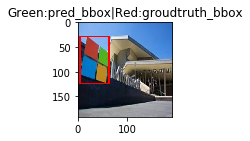

0071.jpg
[ 1.0574028  1.5207158  2.1167636 -2.283539 ]
pred 1.0574028
true [0.17708333 0.17708333 0.16145833 0.31770833]
true 4 29 58 95
pred 203 291 406 -438


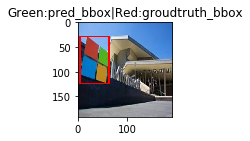

0079.jpg
[ 1.111457   2.0463066  2.5232537 -2.3223116]
pred 1.111457
true [0.20833333 0.67708333 0.109375   0.15625   ]
true 5 55 42 69
pred 213 392 484 -445


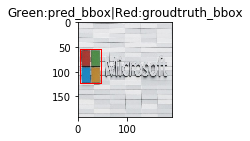

0007.jpg
[ 1.0827316  1.2952567  2.1500957 -1.9043875]
pred 1.0827316
true [0.04166667 0.20833333 0.22395833 0.27083333]
true 34 34 31 61
pred 207 248 412 -365


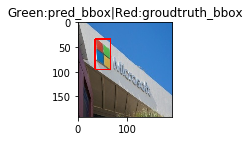

0028.jpg
[ 1.1318243  1.8908625  2.471927  -1.8404899]
pred 1.1318243
true [0.140625   0.38541667 0.1875     0.48958333]
true 1 57 38 89
pred 217 363 474 -353


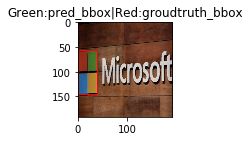

0085.jpg
[ 0.91653556  1.994512    2.4788158  -1.7534592 ]
pred 0.91653556
true [0.02083333 0.28645833 0.203125   0.359375  ]
true 27 71 45 73
pred 175 382 475 -336


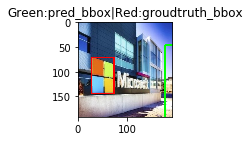

0071.jpg
[ 1.0574028  1.5207158  2.1167636 -2.283539 ]
pred 1.0574028
true [0.17708333 0.17708333 0.16145833 0.31770833]
true 4 29 58 95
pred 203 291 406 -438


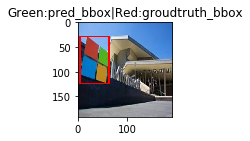

0085.jpg
[ 0.91653556  1.994512    2.4788158  -1.7534592 ]
pred 0.91653556
true [0.02083333 0.28645833 0.203125   0.359375  ]
true 27 71 45 73
pred 175 382 475 -336


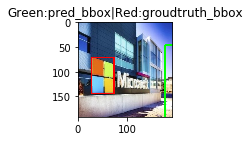

0029.jpg
[ 0.894023   2.0614877  2.607451  -1.9068347]
pred 0.894023
true [0.41145833 0.29166667 0.06770833 0.11458333]
true 9 69 22 80
pred 171 395 500 -366


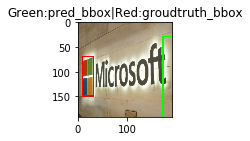

0003.jpg
[ 1.2388854  1.5874233  2.0623393 -2.0604687]
pred 1.2388854
true [0.40625  0.34375  0.0625   0.140625]
true 36 97 25 60
pred 237 304 395 -395


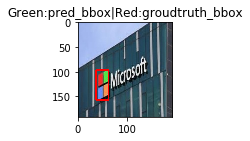

In [110]:
%matplotlib inline
import random

max_image_displayed=5
inds= sample_func(X,max_image_displayed)
for i in range(max_image_displayed):
    plt.figure(figsize=(20,20))
    plt.subplot(1,max_image_displayed,i+1)
    im=X[inds[i]]
    ye = learner.predict(im.reshape(1,192,192,3))
    print(ye)
    x,y,w,h=[int(k) for k in ye*192]
    print("pred",ye[0])
    tx,ty,tw,th=[int(k) for k in Y[inds[i]]*192]
    print("true",Y[inds[i]])
    print("true",tx,ty,tw,th)
    print("pred",x,y,w,h)
    cv2.rectangle(im, (tx,ty),(tx+tw,ty+th), (0,0,255),2)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(im[:,:,[2,1,0]])
    plt.title("Green:pred_bbox|Red:groudtruth_bbox")
    plt.show()


## here is where you use Active Learning to train on sample data which you batched differently

In [113]:
import random
import random
def sample_func(Population, how_many):
    indexes= [ random.choice(range(len(X))) for _ in range(how_many)]
    return indexes

n_queries = 100

for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    inds= sample_func(X, 20)
    print(inds, X[inds].shape)

    
    query_idx = learner.query(inds)
    print(query_idx)

    learner.teach(
        X=X[query_idx].reshape(-1,192,192,3), y=Y[query_idx].reshape(-1,4), only_new=True

    )


Query no. 1
[63, 13, 89, 28, 25, 8, 14, 36, 45, 60, 72, 87, 73, 78, 17, 1, 86, 0, 32, 19] (20, 192, 192, 3)
11
Compiling...
Query no. 2
[4, 91, 8, 62, 82, 40, 47, 68, 68, 11, 41, 88, 49, 86, 36, 32, 22, 4, 26, 61] (20, 192, 192, 3)
14
Compiling...
Query no. 3
[19, 18, 51, 19, 51, 48, 68, 42, 14, 53, 31, 57, 91, 66, 72, 48, 48, 17, 91, 92] (20, 192, 192, 3)
1
Compiling...
Query no. 4
[12, 10, 11, 88, 48, 50, 87, 86, 1, 24, 3, 71, 87, 52, 71, 32, 81, 29, 36, 52] (20, 192, 192, 3)
18
Compiling...
Query no. 5
[11, 29, 79, 92, 14, 2, 81, 6, 92, 67, 12, 87, 77, 34, 60, 81, 91, 27, 19, 42] (20, 192, 192, 3)
11
Compiling...
Query no. 6
[58, 20, 30, 55, 37, 65, 13, 63, 48, 79, 14, 76, 21, 21, 11, 88, 53, 39, 50, 74] (20, 192, 192, 3)
7
Compiling...
Query no. 7
[47, 87, 15, 82, 55, 90, 65, 87, 32, 29, 77, 56, 47, 69, 83, 65, 93, 23, 17, 23] (20, 192, 192, 3)
5
Compiling...
Query no. 8
[1, 56, 87, 0, 6, 54, 93, 64, 40, 69, 56, 69, 22, 53, 59, 76, 45, 28, 78, 35] (20, 192, 192, 3)
18
Compiling...


17
Compiling...
Query no. 67
[33, 48, 32, 26, 5, 28, 5, 91, 36, 73, 57, 48, 67, 34, 57, 38, 24, 58, 9, 9] (20, 192, 192, 3)
8
Compiling...
Query no. 68
[25, 26, 36, 69, 94, 8, 8, 79, 21, 12, 50, 85, 79, 19, 21, 44, 56, 7, 47, 60] (20, 192, 192, 3)
2
Compiling...
Query no. 69
[7, 33, 75, 29, 58, 78, 47, 34, 42, 43, 74, 16, 2, 14, 49, 43, 65, 70, 0, 64] (20, 192, 192, 3)
5
Compiling...
Query no. 70
[59, 59, 91, 93, 79, 74, 45, 71, 59, 62, 50, 73, 80, 93, 2, 43, 15, 6, 19, 89] (20, 192, 192, 3)
16
Compiling...
Query no. 71
[69, 60, 57, 67, 13, 55, 56, 12, 69, 69, 57, 64, 56, 69, 51, 17, 58, 92, 94, 89] (20, 192, 192, 3)
15
Compiling...
Query no. 72
[66, 70, 73, 37, 64, 45, 79, 18, 35, 18, 64, 16, 39, 11, 52, 10, 76, 31, 50, 60] (20, 192, 192, 3)
7
Compiling...
Query no. 73
[21, 63, 88, 46, 33, 15, 59, 79, 33, 77, 12, 65, 49, 35, 74, 15, 15, 50, 1, 20] (20, 192, 192, 3)
1
Compiling...
Query no. 74
[38, 34, 62, 42, 18, 71, 77, 86, 66, 53, 94, 39, 71, 86, 73, 94, 47, 67, 9, 26] (20, 192, 192

# plot result AFTER active learning 

In [ ]:
inds= sample_func(X, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.06723595  0.4982073  -0.6830913   0.53451836]
pred 0.067235954
true [0.19270833 0.36458333 0.15104167 0.34375   ]
true 37 70 29 66
pred 12 95 -131 102


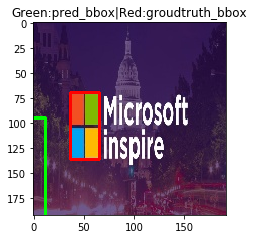

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.3947204   0.48123822  4.2928963   0.4738799 ]
pred -0.3947204
true [0.140625   0.38541667 0.1875     0.48958333]
true 27 74 36 94
pred -75 92 824 90


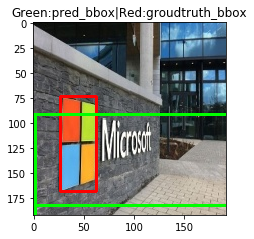

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.05551948  0.48445565 -0.64075416  0.51323134]
pred 0.05551948
true [0.359375   0.22916667 0.046875   0.07291667]
true 69 44 9 14
pred 10 93 -123 98


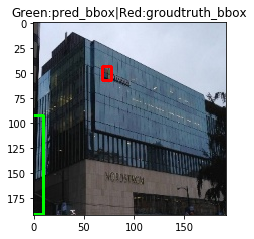

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.01731606  0.48982003 -0.38694513  0.5152726 ]
pred -0.017316058
true [0.39583333 0.38541667 0.078125   0.16666667]
true 76 74 15 32
pred -3 94 -74 98


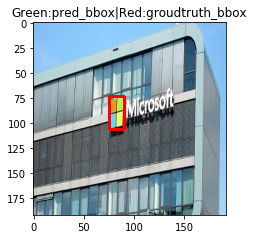

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 0.05381107  0.49840966 -0.6374193   0.52704334]
pred 0.05381107
true [0.046875   0.36458333 0.16145833 0.328125  ]
true 9 70 31 63
pred 10 95 -122 101


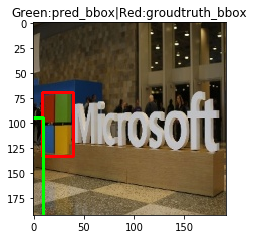

In [115]:
%matplotlib inline
import random

max_image_displayed=5
inds= sample_func(X,max_image_displayed)
for i in range(max_image_displayed):
    plt.figure(figsize=(20,20))
    plt.subplot(1,max_image_displayed,i+1)
    im=X[inds[i]]
    ye = learner.predict(im.reshape(1,192,192,3))
    print(ye)
    x,y,w,h=[int(k) for k in ye*192]
    print("pred",ye[0])
    tx,ty,tw,th=[int(k) for k in Y[inds[i]]*192]
    print("true",Y[inds[i]])
    print("true",tx,ty,tw,th)
    print("pred",x,y,w,h)
    cv2.rectangle(im, (tx,ty),(tx+tw,ty+th), (0,0,255),2)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(im[:,:,[2,1,0]])
    plt.title("Green:pred_bbox|Red:groudtruth_bbox")
    plt.show()


## save the entire model and weights